In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
# Fixing random seeds
torch.manual_seed(1234)
rs = np.random.RandomState(1234)

In [3]:
 with open("./datasets/lorenz/lorenz_dataset.pickle", "rb") as infile:
            dataset = pickle.load(infile)


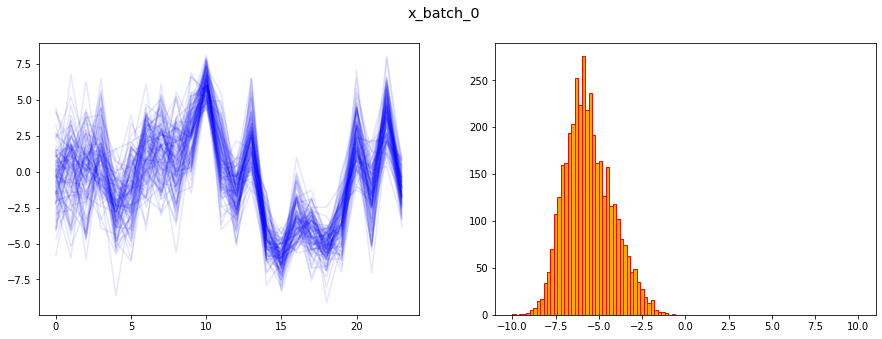

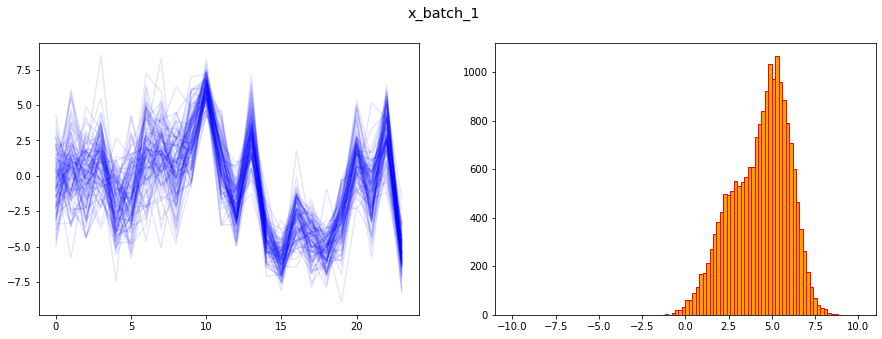

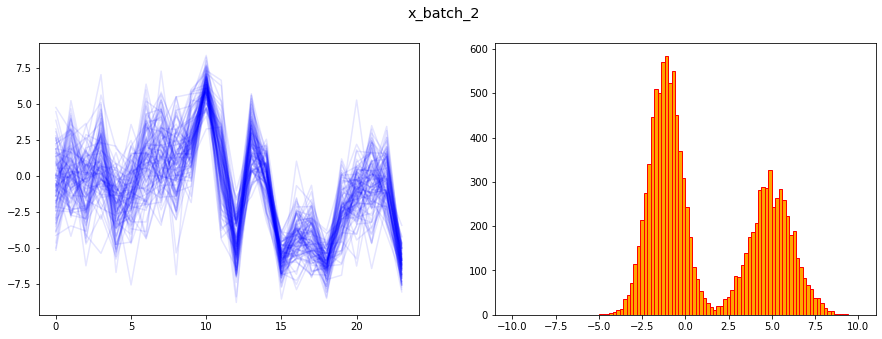

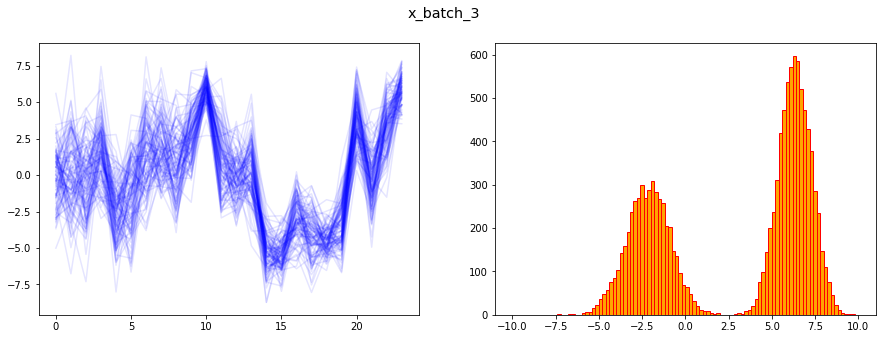

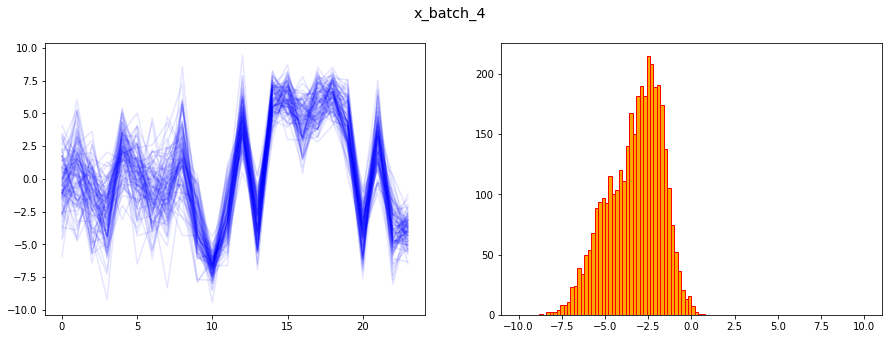

In [4]:
for i in range(5):
    f, axarr = plt.subplots(1,2, figsize=(15,5))
    axarr[0].plot(dataset['x_train']['condition_{}'.format(i)][:100].T,c='b',alpha=0.1)
    axarr[1].hist(dataset['y_train']['condition_{}'.format(i)].flatten(),bins=100,color='orange',edgecolor='red',range=(-10,10))
    f.suptitle('x_batch_{}'.format(i),fontsize="x-large")
    
    plt.plot()

In [5]:
x_train = np.concatenate(list(dataset["x_train"].values()))
y_train = np.concatenate(list(dataset["y_train"].values()))

x_val = np.concatenate(list(dataset["x_val"].values()))
y_val = np.concatenate(list(dataset["y_val"].values()))


In [6]:
#Calculate CRPS
def calc_crps(ground_truth, predictions, predictions2):
    return np.absolute(predictions - ground_truth).mean() - 0.5 * np.absolute(predictions - predictions2).mean()

In [7]:
class Generator(nn.Module):
    def __init__(self, noise_size, x_batch_size, generator_latent_size):
        super().__init__()

        self.noise_size = noise_size
        self.x_batch_size = x_batch_size
        self.generator_latent_size = generator_latent_size
        self.cond_to_latent = nn.GRU(input_size=1,
                                     hidden_size=generator_latent_size)

        self.model = nn.Sequential(
            nn.Linear(in_features=generator_latent_size + noise_size,
                      out_features=generator_latent_size + noise_size),
            nn.ReLU(),
            nn.Linear(in_features=generator_latent_size + noise_size, out_features=1)
        )

    def forward(self, noise, x_batch):
        x_batch = x_batch.view(-1, self.x_batch_size, 1)
        x_batch = x_batch.transpose(0, 1)
        x_batch_latent, _ = self.cond_to_latent(x_batch)
        x_batch_latent = x_batch_latent[-1]
        g_input = torch.cat((x_batch_latent, noise), dim=1)
        output = self.model(g_input)

        return output

In [8]:
class Discriminator(nn.Module):
    def __init__(self, x_batch_size, discriminator_latent_size):
        super().__init__()
        self.discriminator_latent_size = discriminator_latent_size
        self.x_batch_size = x_batch_size
        self.input_to_latent = nn.GRU(input_size=1,
                                      hidden_size=discriminator_latent_size)

        self.model = nn.Sequential(
            nn.Linear(in_features=discriminator_latent_size, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, prediction, x_batch):
        d_input = torch.cat((x_batch, prediction.view(-1, 1)), dim=1)
        d_input = d_input.view(-1, self.x_batch_size + 1, 1)
        d_input = d_input.transpose(0, 1)
        d_latent, _ = self.input_to_latent(d_input)
        d_latent = d_latent[-1]
        output = self.model(d_latent)
        return output


In [9]:
n_steps = 2500
batch_size = 1000
noise_size = 32
x_batch_size = 24
generator_latent_size = 8
discriminator_latent_size = 64
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [10]:
os.makedirs("./results/lorenz", exist_ok=True)

In [11]:
generator = Generator(noise_size=noise_size,
                      x_batch_size=x_batch_size,
                      generator_latent_size=generator_latent_size).to(device)

discriminator = Discriminator(x_batch_size=x_batch_size,
                              discriminator_latent_size=discriminator_latent_size).to(device)

print(generator)
print(discriminator)

Generator(
  (cond_to_latent): GRU(1, 8)
  (model): Sequential(
    (0): Linear(in_features=40, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=1, bias=True)
  )
)
Discriminator(
  (input_to_latent): GRU(1, 64)
  (model): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [12]:
x_train = torch.tensor(x_train, device=device, dtype=torch.float32)
y_train = torch.tensor(y_train, device=device, dtype=torch.float32)
x_val = torch.tensor(x_val, device=device, dtype=torch.float32)

In [13]:
optimizer_g = torch.optim.RMSprop(generator.parameters())
optimizer_d = torch.optim.RMSprop(discriminator.parameters())
adversarial_loss = nn.BCELoss()
adversarial_loss = adversarial_loss.to(device)

In [14]:
best_crps = np.inf
for step in range(n_steps):

    idx = rs.choice(x_train.shape[0], batch_size)
    x_batch = x_train[idx]
    y_batch = y_train[idx]
    d_loss = 0
    discriminator.zero_grad()
    d_real_decision = discriminator(y_batch, x_batch)
    d_real_loss = adversarial_loss(d_real_decision,
                                   torch.full_like(d_real_decision, 1, device=device))
    d_real_loss.backward()
    d_loss += d_real_loss.detach().cpu().numpy()
    # train discriminator on fake data
    noise_batch = torch.tensor(rs.normal(0, 1, (x_batch.size(0), noise_size)),
                               device=device, dtype=torch.float32)
    x_fake = generator(noise_batch, x_batch).detach()
    d_fake_decision = discriminator(x_fake, x_batch)
    d_fake_loss = adversarial_loss(d_fake_decision,
                                   torch.full_like(d_fake_decision, 0, device=device))
    d_fake_loss.backward()

    optimizer_d.step()
    d_loss += d_fake_loss.detach().cpu().numpy()

    d_loss = d_loss / 2

    generator.zero_grad()
    noise_batch = torch.tensor(rs.normal(0, 1, (batch_size, noise_size)), device=device,
                               dtype=torch.float32)
    x_fake = generator(noise_batch, x_batch)
    d_g_decision = discriminator(x_fake, x_batch)
    g_loss = -1 * adversarial_loss(d_g_decision, torch.full_like(d_g_decision, 0, device=device))

    g_loss.backward()
    optimizer_g.step()

    g_loss = g_loss.detach().cpu().numpy()

    # Validation
    if step % 100 == 0:
        with torch.no_grad():
            generator.eval()

            predictions = []
            for _ in range(200):
                noise_batch = torch.tensor(rs.normal(0, 1, (x_val.size(0), noise_size)),
                                           device=device,
                                           dtype=torch.float32)
                predictions.append(generator(noise_batch, x_val).cpu().detach().numpy())

            predictions = np.stack(predictions)

            generator.train()

        crps = calc_crps(y_val, predictions[:100], predictions[100:])

        if crps <= best_crps:
            best_crps = crps
            torch.save({'g_state_dict': generator.state_dict()},
                       "./results/lorenz/best.torch")

        print("step : {} , d_loss : {} , g_loss : {}, crps : {}, best crps : {}".format(step, d_loss, g_loss,crps,best_crps))

step : 0 , d_loss : 0.6941152215003967 , g_loss : -0.6586312651634216, crps : 3.344949433900116, best crps : 3.344949433900116
step : 100 , d_loss : 0.6664214134216309 , g_loss : -0.6576168537139893, crps : 2.2759360680211023, best crps : 2.2759360680211023
step : 200 , d_loss : 0.6725625097751617 , g_loss : -0.6033901572227478, crps : 1.977520279817575, best crps : 1.977520279817575
step : 300 , d_loss : 0.665946364402771 , g_loss : -0.6583986878395081, crps : 1.7279186594323996, best crps : 1.7279186594323996
step : 400 , d_loss : 0.6813683211803436 , g_loss : -0.6837272047996521, crps : 1.6753224308203096, best crps : 1.6753224308203096
step : 500 , d_loss : 0.6884499192237854 , g_loss : -0.6621543765068054, crps : 1.697793982330794, best crps : 1.6753224308203096
step : 600 , d_loss : 0.6850287020206451 , g_loss : -0.6811928749084473, crps : 1.6464584217948008, best crps : 1.6464584217948008
step : 700 , d_loss : 0.6902402639389038 , g_loss : -0.650897741317749, crps : 1.6009297204

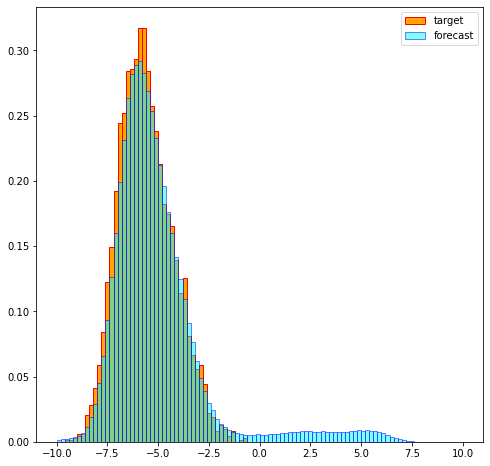

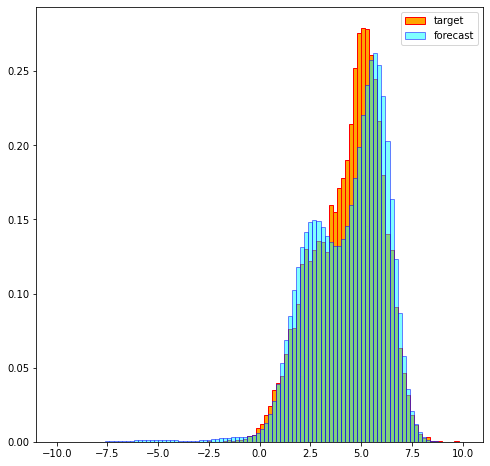

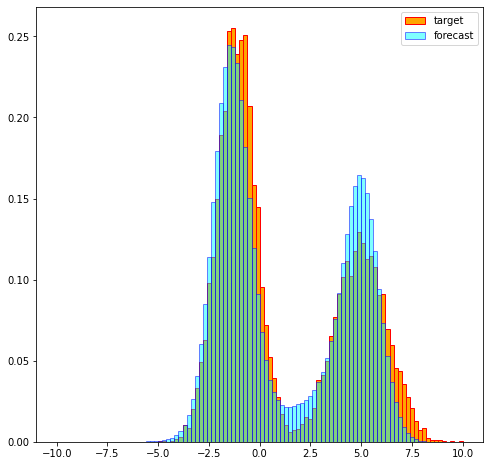

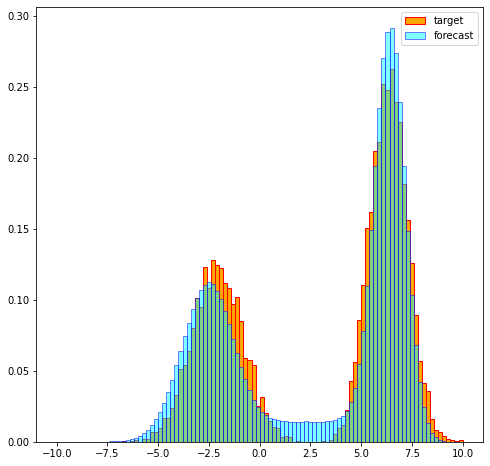

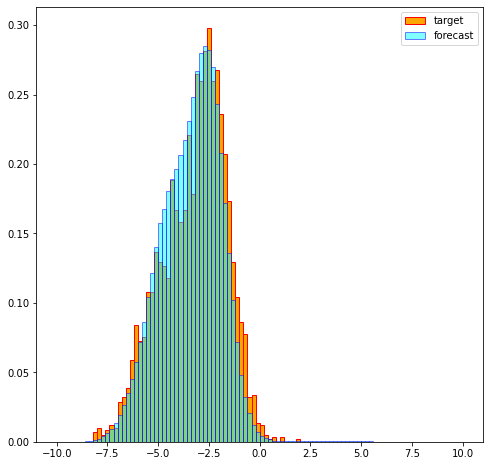

In [15]:
checkpoint = torch.load("./results/lorenz/best.torch")
generator.load_state_dict(checkpoint['g_state_dict'])
for i in range(5):
    
    x_test = torch.tensor(dataset['x_test']['condition_{}'.format(i)], device=device, dtype=torch.float32)
    predictions = []
    for _ in range(200):
        with torch.no_grad():
            generator.eval()
            noise_batch = torch.tensor(rs.normal(0, 1, (x_test.size(0), noise_size)), device=device,
                                           dtype=torch.float32)
            predictions.append(generator(noise_batch, x_test).detach().cpu().numpy().flatten())
    
    predictions = np.stack(predictions).flatten()
    y_test = dataset['y_test']['condition_{}'.format(i)].flatten()
    
    f, axarr = plt.subplots(1,1, figsize=(8,8))
    axarr.hist(y_test,bins=100,color='orange',edgecolor='red',density=True,label="target",range=(-10,10))
    axarr.hist(predictions,bins=100,color='cyan',edgecolor='blue',density=True,alpha=0.5,label="forecast",range=(-10,10))
    plt.legend()
    
    plt.plot()

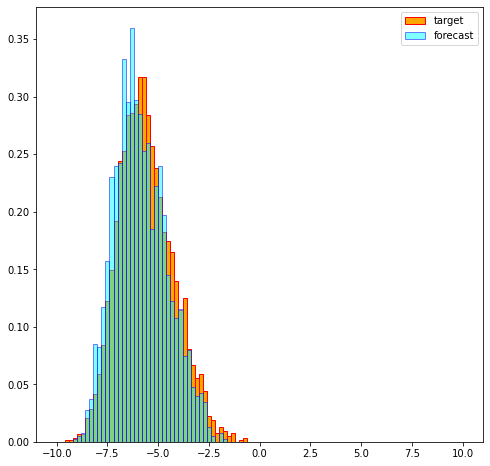

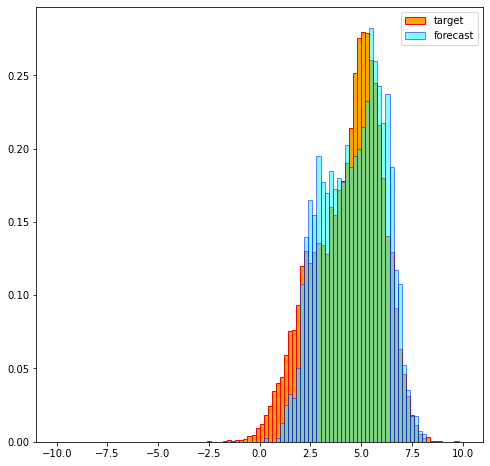

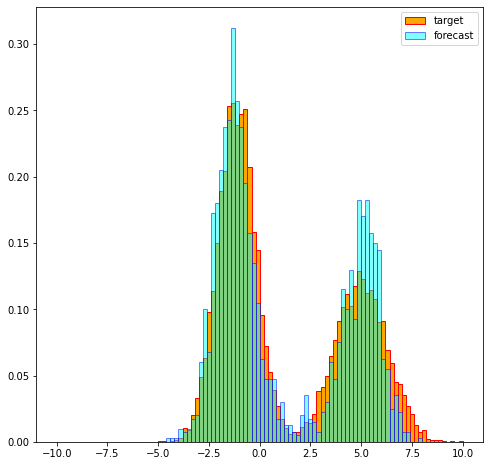

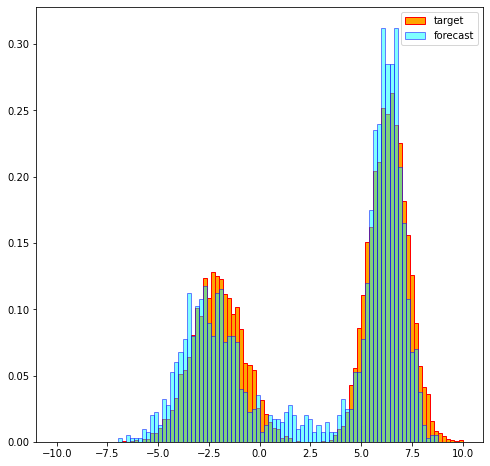

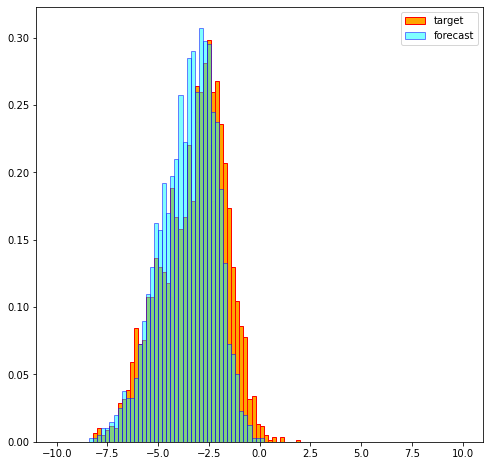

In [16]:

for i in range(5):
    sample= dataset['x_test']['condition_{}'.format(i)][10]
    sample= sample[np.newaxis,:]
    sample = np.repeat(sample,2000,axis=0)
    x_test = torch.tensor(sample, device=device, dtype=torch.float32)
    
    predictions = []
    with torch.no_grad():
        generator.eval()
        noise_batch = torch.tensor(rs.normal(0, 1, (x_test.size(0), noise_size)), device=device,
                                       dtype=torch.float32)
        predictions = generator(noise_batch, x_test).detach().cpu().numpy().flatten()
    
    y_test = dataset['y_test']['condition_{}'.format(i)].flatten()
    
    f, axarr = plt.subplots(1,1, figsize=(8,8))
    axarr.hist(y_test,bins=100,color='orange',edgecolor='red',density=True,label="target",range=(-10,10))
    axarr.hist(predictions,bins=100,color='cyan',edgecolor='blue',density=True,alpha=0.5,label="forecast",range=(-10,10))
    plt.legend()
    
    plt.plot()

In [17]:
x_test = np.concatenate(list(dataset["x_test"].values()))
y_test = np.concatenate(list(dataset["y_test"].values()))

x_test = torch.tensor(x_test, device=device, dtype=torch.float32)
y_test = y_test.flatten()
predictions = []
for _ in range(200):
    with torch.no_grad():
        generator.eval()
        noise_batch = torch.tensor(rs.normal(0, 1, (x_test.size(0), noise_size)), device=device,
                                       dtype=torch.float32)
        predictions.append(generator(noise_batch, x_test).detach().cpu().numpy().flatten())

predictions = np.stack(predictions)
crps = calc_crps(y_test, predictions[:100], predictions[100:])
print("Test CRPS = {}".format(crps))

Test CRPS = 1.5352074877009354
